# **Final Report: Exploring Housing Prices**

### **By Yeojun Han, Jay Hou, Lavanya Kandhari, & Lillian Milroy**

## Introduction

Some of the most expensive real estate in the world is located on the California coast.[1] Over the last
several decades, it has become evident that rising sea levels, climate change, and coastal erosion threaten
the economic and physical stability of coastal properties.[2,3,4] Research reported by the California
Legislative Analyst’s Office states that “over $150 billion of property equating to more than 6% of the
state’s GDP and 600,000 people could be impacted by dynamic flooding by 2100”.[2,3]

There is disagreement among scientists, government organizations, and coastal residents about how to
address the situation without sacrificing the value of at-risk properties.[1] Continued study of the
relationship between property value and coastline proximity will be a useful way to gauge the efficacy of
whatever measures are implemented, as well as public sentiment.

We are working with data originally collected from the 1990 California census, containing the variables
longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households,
median_income, median_house_value, and ocean_proximity.[5]

We hope to establish whether or not ocean proximity had an effect on median home value in 1990, by
comparing median home prices of inland houses and houses less than one hour away from the ocean. Our null hypothesis is that ocean proximity did not have an affect on median house value, and our alternative hypothesis is that houses in closer proximity to the ocean had a greater median house value in 1990.<br><br>
$H_0: \mu (\$<1H ocean) - \mu (\$ inland) = 0 $<br>
$H_a: \mu (\$<1H ocean) - \mu (\$ inland) > 0 $<br><br>
There are extreme values present in this data, so to mitigate their impact on our results, median and IQR
will be used as parameters.

## Preliminary Results


In [108]:
library(tidyverse)
library(broom)

housing <- read_csv("housing.csv")
head(housing)

Rows: 20640 Columns: 10
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (1): ocean_proximity
dbl (9): longitude, latitude, housing_median_age, total_rooms, total_bedroom...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY
-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY
-122.24,37.85,52,1467,190,496,177,7.2574,352100,NEAR BAY
-122.25,37.85,52,1274,235,558,219,5.6431,341300,NEAR BAY
-122.25,37.85,52,1627,280,565,259,3.8462,342200,NEAR BAY
-122.25,37.85,52,919,213,413,193,4.0368,269700,NEAR BAY


When we plot the median house value by ocean proximity, we can see that the `INLAND` house values tend to be cheaper, whereas `<1H OCEAN` house values tend to be more expensive.

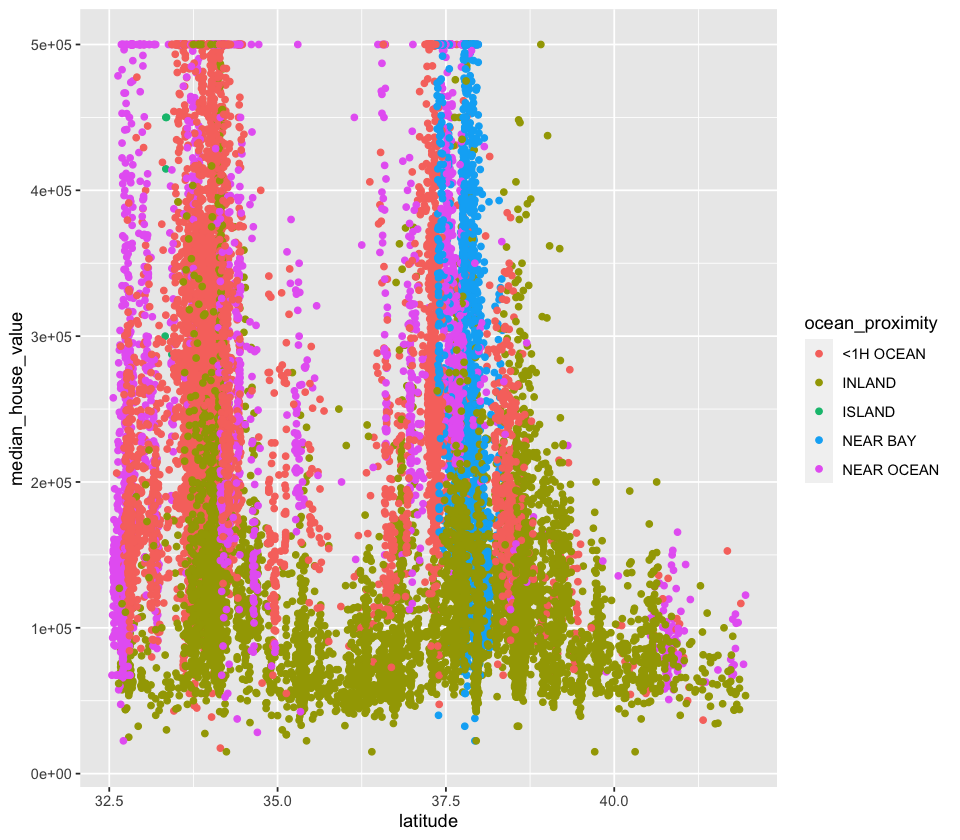

In [109]:
ggplot(housing, aes(x=latitude, y=median_house_value, color=ocean_proximity)) + 
    geom_point()

We can take a deeper look into the difference in median housing prices between inland houses and other houses in California. In this boxplot, we can see that that the inland house value seems much lower than the ones closer to the ocean.

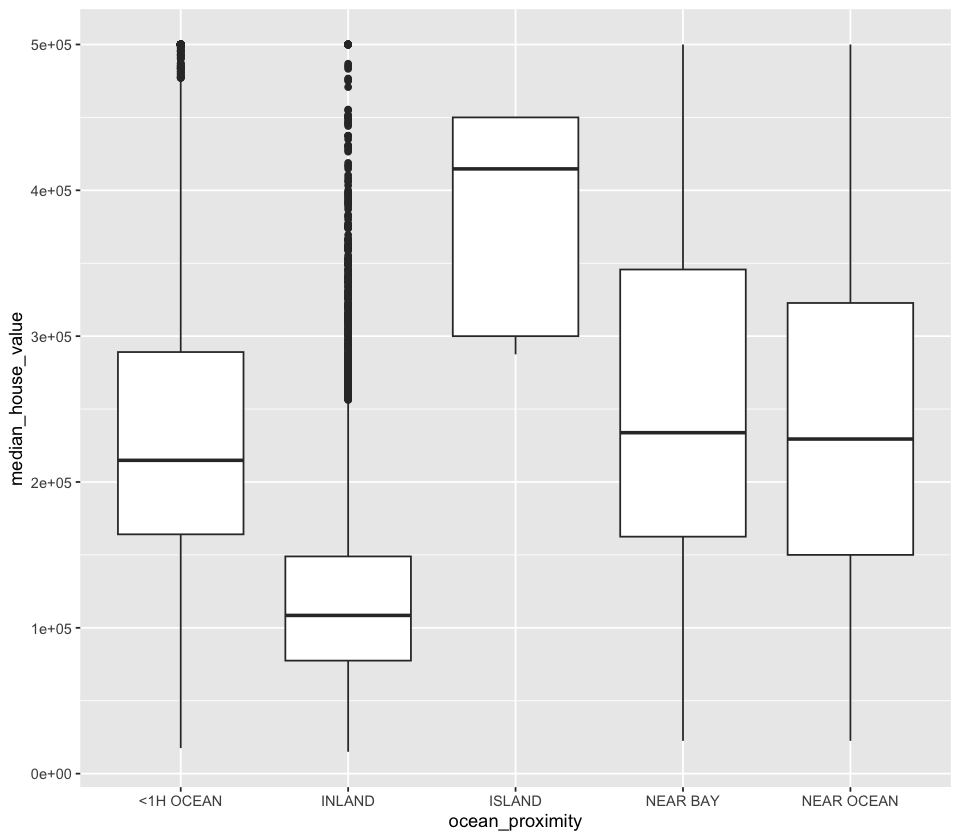

In [110]:
ggplot(housing, aes(x=ocean_proximity, y=median_house_value)) + 
    geom_boxplot()

If we want to compare the median housing price between inland California houses and some other group in `ocean_proximity`, we want to choose ones that have a relatively large number since it will help in decreasing the variance of our sample distribution. When we plot the number of observations in each group, we can see that the `<1H OCEAN` and `INLAND` have very high number of observations compared to the other groups. So, it would be a good idea to focus our project in comparing the median housing price between these two groups.

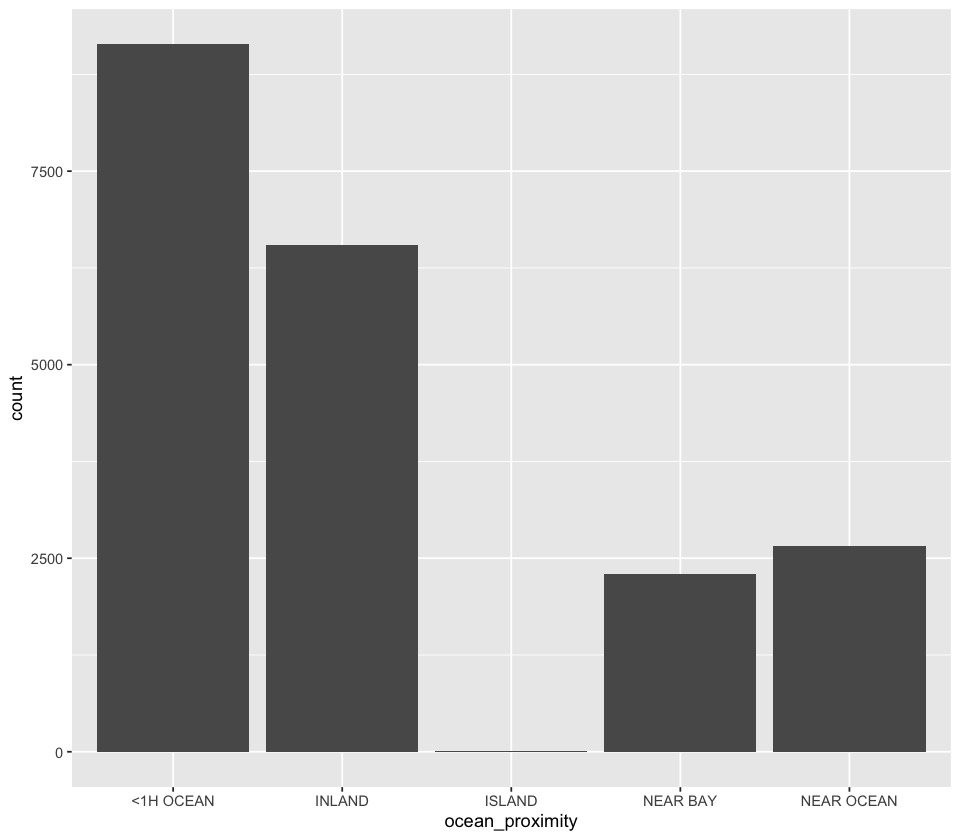

In [111]:
ggplot(housing, aes(x=ocean_proximity)) + 
    geom_bar()

Additionally, we should see whether `<1H OCEAN` and `INLAND` are roughly normally distributed. We know that both groups have at least 6500 samples so we have a large enough sample size, and the population of California is roughly 39 million, so we can be assured that our sample is less than 10% of the population. 

In [112]:
ocean <- housing %>% 
    filter(ocean_proximity == "<1H OCEAN")
inland <- housing %>% 
    filter(ocean_proximity == "INLAND")

nrow(ocean)
nrow(inland)

[1] 9136

[1] 6551

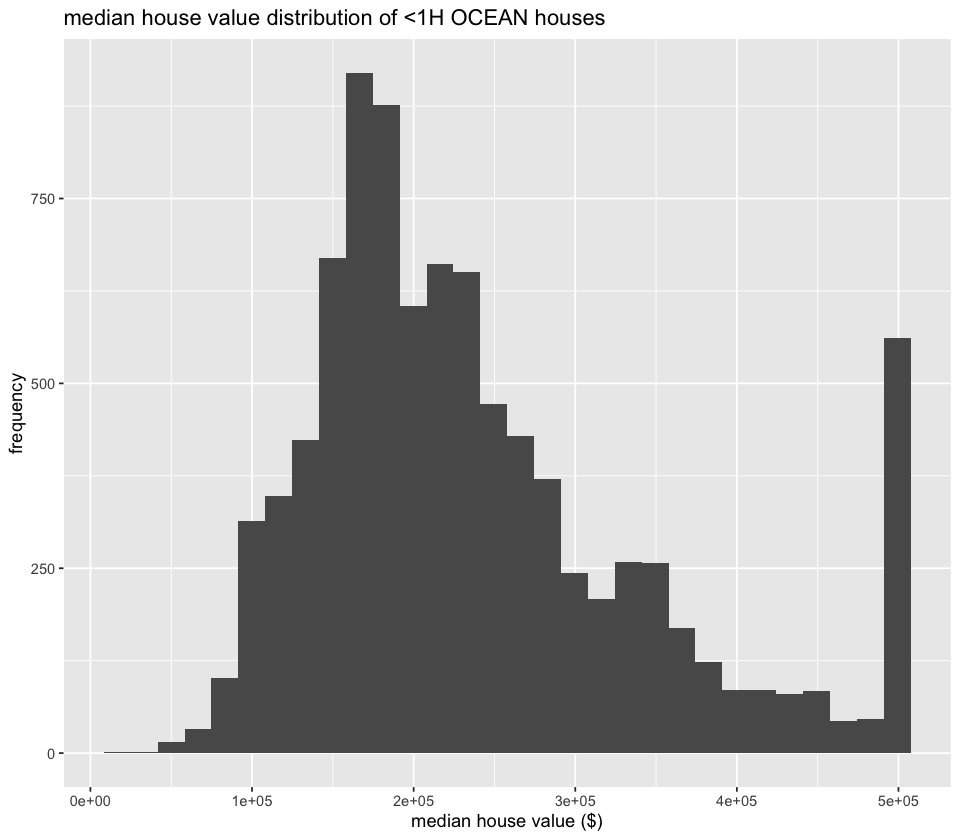

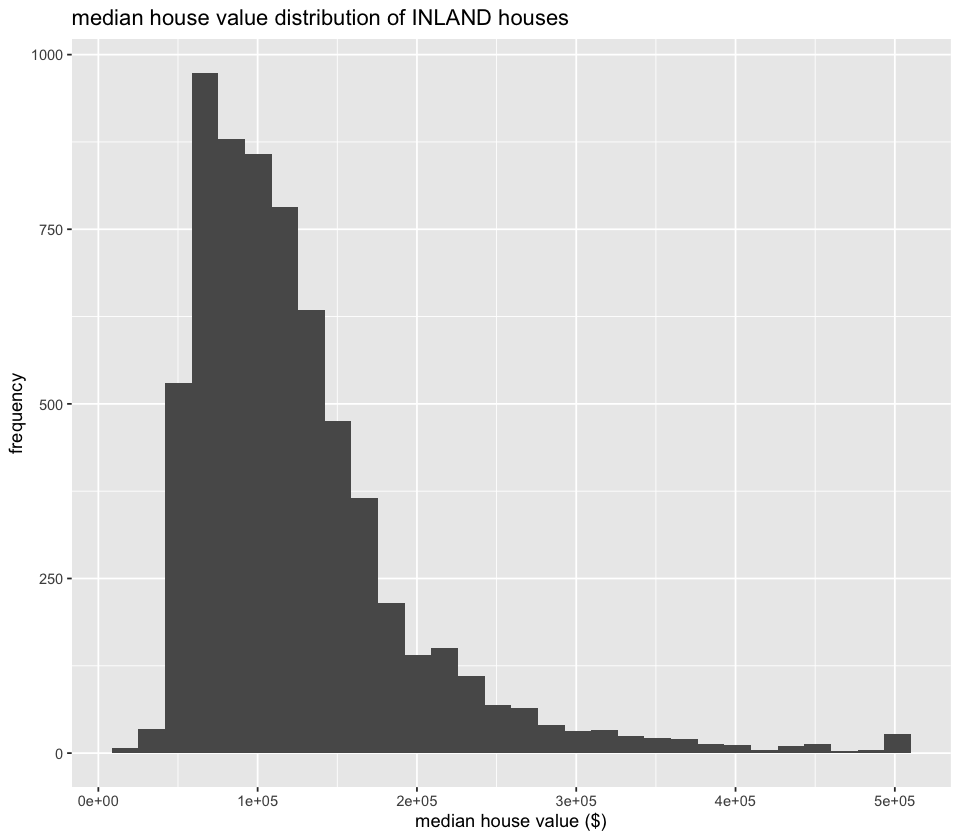

In [113]:
ggplot(ocean, aes(x=median_house_value)) + 
    geom_histogram(bins=30) + 
    labs(x="median house value ($)", y="frequency", title="median house value distribution of <1H OCEAN houses")

ggplot(inland, aes(x=median_house_value)) + 
    geom_histogram(bins=30) +
    labs(x="median house value ($)", y="frequency", title="median house value distribution of INLAND houses")


We can see that the distribution of `<1H OCEAN` houses are roughly normally distributed but bimodal with a peak at around 100,000 dollars and another at 500,000 dollars. However, the distribution of `INLAND` houses are skewed to the right with a peak at 100,100 dollars. Since the sample is not normally distributed, we may have to use bootstrapping to estimate the sampling distribution so that we can use formulae for normal distributions such as the t-test. 

Lastly, let's find estimates for each group:  
- `<1H ocean` has a mean of 240084, median of 214850, and an IQR of 125000.  
- `inland` has a mean of 124805, median of 108500, and an IQR of 71450. 

In [169]:
print("<1H ocean")
summary(ocean$median_house_value)
print("inland")
summary(inland$median_house_value)

[1] "<1H ocean"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  17500  164100  214850  240084  289100  500001 

[1] "inland"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  14999   77500  108500  124805  148950  500001 

## Analysis

In [170]:
# create a dataset that only has two columns: median_house_value and ocean_proximity 
# filter ocean_proximity column to only have <1H ocean and inland, remove any NA 
# values from the dataset

housing_filtered <- housing %>% 
    filter(ocean_proximity %in% c("<1H OCEAN", "INLAND"))%>%
    select(median_house_value,ocean_proximity) %>% 
    filter(!is.na(median_house_value))

head(housing_filtered)

median_house_value,ocean_proximity
<dbl>,<chr>
431000,<1H OCEAN
217000,<1H OCEAN
247600,<1H OCEAN
283500,<1H OCEAN
216900,<1H OCEAN
282500,<1H OCEAN


In [171]:
# summary of data
housing_filtered_summary <- 
    housing_filtered %>% 
    filter(!is.na(median_house_value)) %>% 
    group_by(ocean_proximity) %>% 
    summarise(sample_mean = mean(median_house_value), 
              sample_median = median(median_house_value),
              sample_sd = sd(median_house_value),
              IQR = IQR(median_house_value),
              n=n())
housing_filtered_summary
summary(housing_filtered)

ocean_proximity,sample_mean,sample_median,sample_sd,IQR,n
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
<1H OCEAN,240084.3,214850,106124.29,125000,9136
INLAND,124805.4,108500,70007.91,71450,6551


 median_house_value ocean_proximity   
 Min.   : 14999     Length:15687      
 1st Qu.:111300     Class :character  
 Median :166900     Mode  :character  
 Mean   :191943                       
 3rd Qu.:241100                       
 Max.   :500001                       

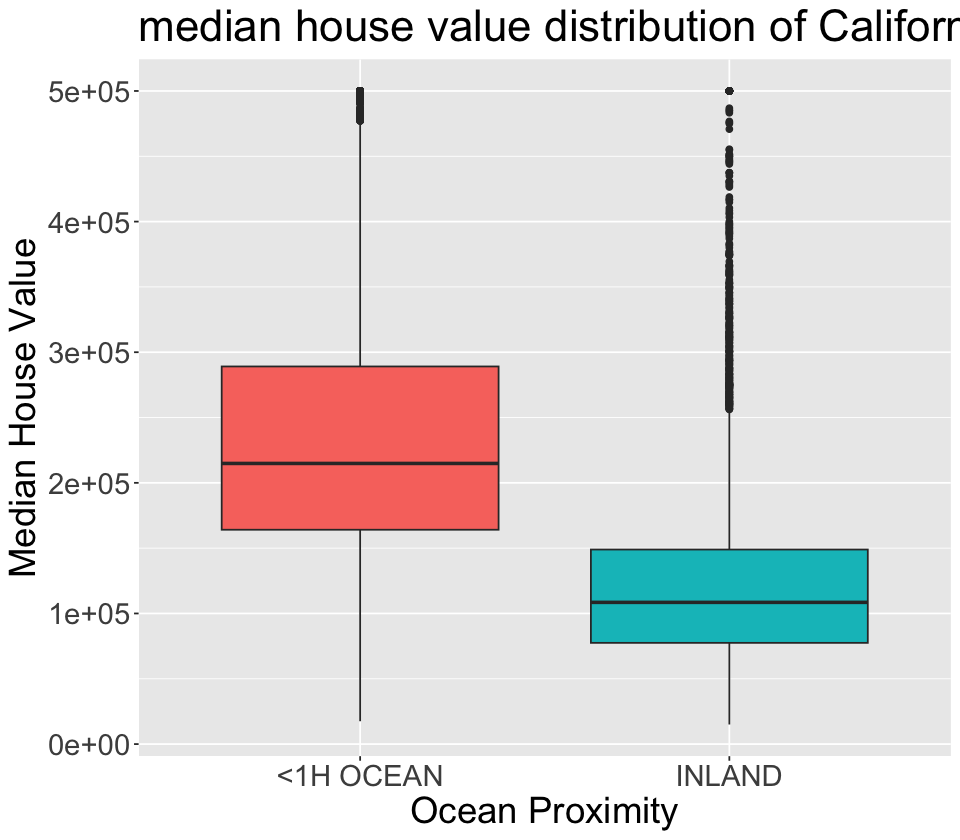

In [172]:
# plot the distribution for both classes
ocean_proximity_boxplots <-
    housing_filtered %>% 
    ggplot() +
    geom_boxplot(aes(x=ocean_proximity, y=median_house_value, fill = ocean_proximity)) +
    theme(text = element_text(size = 22)) +
    ggtitle("median house value distribution of California houses by ocean proximity") + 
    xlab("Ocean Proximity") + 
    ylab("Median House Value") + 
    guides(fill = FALSE)
ocean_proximity_boxplots

In [173]:
# Take samples of size 100 from both classes

sample_ocean <- housing_filtered %>%
    filter(ocean_proximity == "<1H OCEAN") %>%
    sample_n(size = 100, replace = FALSE) %>%
    subset(select = median_house_value)

sample_inland <- housing_filtered %>%
    filter(ocean_proximity == "INLAND") %>%
    sample_n(size = 100, replace = FALSE) %>%
    subset(select = median_house_value)

head(sample_ocean)
head(sample_inland)

median_house_value
<dbl>
196900
253100
169700
117200
177800
281900


median_house_value
<dbl>
286300
121200
93300
95300
216800
86500


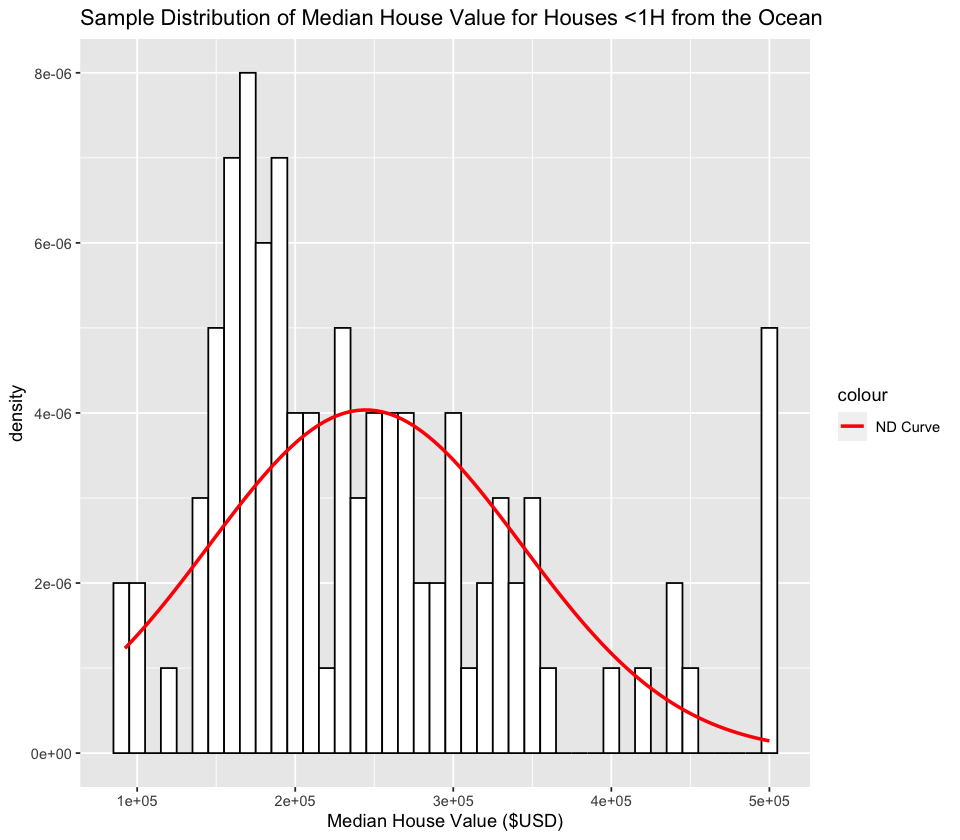

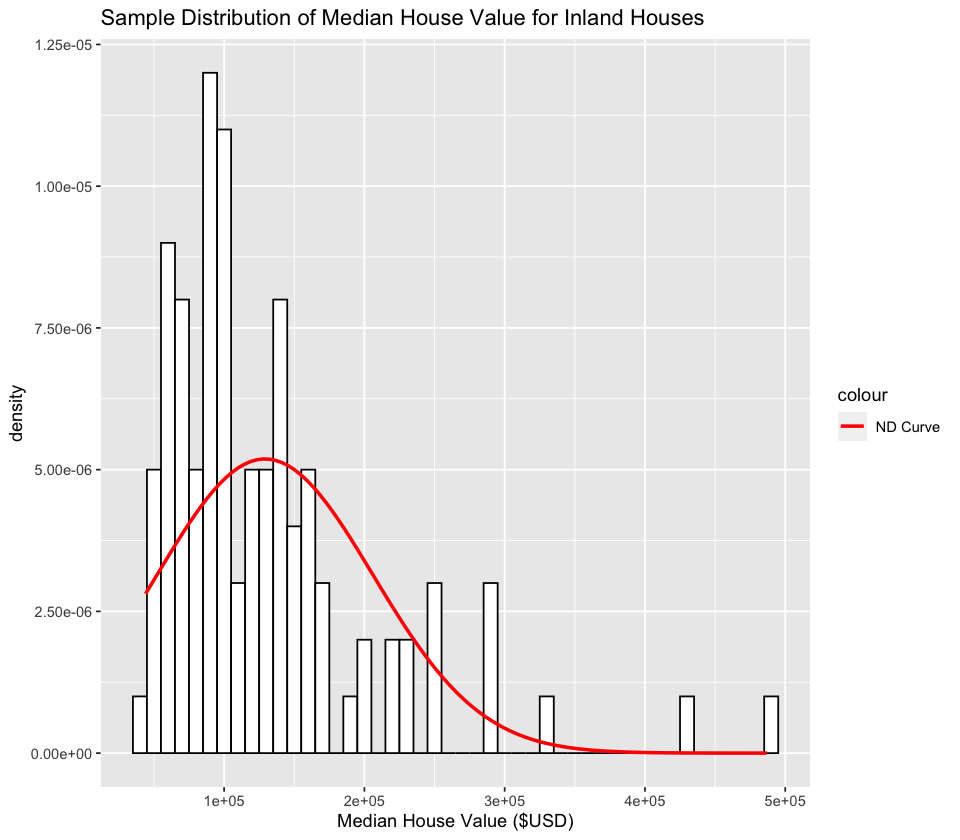

In [174]:
# Plot histograms with ND curve
options(repr.plot.width = 8, repr.plot.height = 7)

ocean_norm_dist <- sample_ocean %>%
    ggplot(aes(x = median_house_value)) +
    geom_histogram(aes(y = ..density..), binwidth = 10000, color = "black", fill = "white") +
    stat_function(fun = dnorm, args = list(mean = mean(sample_ocean$median_house_value), 
                                           sd = sd(sample_ocean$median_house_value)),
                  aes(color = "ND Curve"), size = 1) +
    scale_color_manual(values = "red") +
    ggtitle("Sample Distribution of Median House Value for Houses <1H from the Ocean") +
    xlab("Median House Value ($USD)")

inland_norm_dist <- sample_inland %>%
    ggplot(aes(x = median_house_value)) +
    geom_histogram(aes(y = ..density..), binwidth = 10000, color = "black", fill = "white") +
    stat_function(fun = dnorm, args = list(mean = mean(sample_inland$median_house_value), 
                                           sd = sd(sample_inland$median_house_value)),
                  aes(color = "ND Curve"), size = 1) +
    scale_color_manual(values = "red") +
    ggtitle("Sample Distribution of Median House Value for Inland Houses") +
    xlab("Median House Value ($USD)")

ocean_norm_dist
inland_norm_dist

In [175]:
# plot the histogram with the t-distribution (similar to worksheet 8 Q2.1)


In [176]:
# find the mean, median, sd, IQR, etc. of the above dataset 
# and put into a table (include table name!!)

# summary stats for sample_ocean

sample_ocean_summary <- sample_ocean %>% 
    summarise(sample_mean = mean(median_house_value), 
              sample_median = median(median_house_value),
              sample_sd = sd(median_house_value),
              IQR = IQR(median_house_value),
              name = "ocean sample", n=n())

# summary stats for sample_inland

sample_inland_summary <- sample_inland %>% 
    summarise(sample_mean = mean(median_house_value), 
              sample_median = median(median_house_value),
              sample_sd = sd(median_house_value),
              IQR = IQR(median_house_value),
              name = "inland sample", n=n())

samples_summary_stats <- bind_rows(sample_ocean_summary, sample_inland_summary) %>%
    select(name, sample_mean, sample_median, sample_sd, IQR,n)

#### Summary Statistics for <1H Ocean Sample (n = 100) and Inland Sample (n = 100)

In [177]:
samples_summary_stats

name,sample_mean,sample_median,sample_sd,IQR,n
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
ocean sample,244544,221250,98859.31,125500,100
inland sample,129127,102350,76886.05,69900,100


#### talk about CLT
fill in!!

In [178]:
sample_ocean_summary

sample_mean,sample_median,sample_sd,IQR,name,n
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
244544,221250,98859.31,125500,ocean sample,100


### Finding the test statistic

$$ T = \frac{\bar{x}_{\text{Ocean}} - \bar{x}_{\text{Inland}}}{\sqrt{\frac{s^2_{\text{Ocean}}}{n_1}+\frac{s^2_{\text{Inland}}}{n_2}}} $$ where $\bar{x}_{\text{Ocean}}$ and $\bar{x}_{\text{Inland}}$ are the sample means of median house value for <1H OCEAN and INLAND houses, respectively; $s^2_{\text{Ocean}}$ and $s^2_{\text{Inland}}$ are the sample variances for <1H OCEAN and INLAND houses, respectively; and $n_1$ and $n_2$ are the sample size for <1H OCEAN and INLAND houses, respectively.

In [179]:
# find test statistic 

housing_test_stat <- (samples_summary_stats$sample_mean[1] - samples_summary_stats$sample_mean[2]) /
                      sqrt((samples_summary_stats$sample_sd[1]^2+samples_summary_stats$sample_sd[2]^2) / 100)
housing_test_stat

[1] 9.215796

In [189]:
# find v (W8 Q3.3.4)

num=((samples_summary_stats$sample_sd[1]^2+samples_summary_stats$sample_sd[2]^2/100)/100)^2
den=((samples_summary_stats$sample_sd[1]^4+samples_summary_stats$sample_sd[2]^4)/(10000*99))
v=num/den
v
df = 100 + 100 - 2
df

[1] 73.36106

[1] 198

In [190]:
# find the null distribution and compare to current distribution
samples_summary_stats <-
    samples_summary_stats %>% 
    mutate(null_std_error = sqrt(samples_summary_stats$sample_sd[1]^2/100 + samples_summary_stats$sample_sd[2]^2/100))

# null_dist <- rt(100000, df = df)

# # plot the null and current observed distributions

# obs_null_dist <- ggplot() +
#     geom_density(aes(x = null_dist), color = "blue", alpha = 0.6) +
#     geom_vline(xintercept = 0, color = "black", linetype = "dashed") +
#     geom_vline(xintercept = housing_test_stat, color = "black", linetype = "solid") +
#     labs(x = "Test Statistic", title = "Observed and Null Distributions") 

# obs_null_dist
samples_summary_stats


name,sample_mean,sample_median,sample_sd,IQR,n,null_std_error
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
ocean sample,244544,221250,98859.31,125500,100,12523.83
inland sample,129127,102350,76886.05,69900,100,12523.83


In [191]:
# perform a two-sample t-test 
test=tidy(t.test(x = sample_ocean %>% pull(median_house_value),
                 y = sample_inland %>% pull(median_house_value),
                 alternative = "two.sided"))
test


estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
115417,244544,129127,9.215796,6.500068e-17,186.6835,90710.63,140123.5,Welch Two Sample t-test,two.sided


In [192]:
# construct an interval 

In [193]:
# get p-value 
p_val=2*pt(housing_test_stat, v, lower.tail=FALSE)
p_val
# plot the distribution with p-value 

[1] 7.031169e-14

#### REJECT or FAIL TO REJECT?
Since out p value is less that 0.05 therefore concluding that at 5 % significance level we reject the null hypothesis that ocean proximity did not have an affect on median house value . 


## Type I error or Type II error? 
We are likely to make a type 1 error if we rejected the null hypothesis but it was actually true  


In [16]:

# conduct repeat bootstrap analysis

# compare results to confidence interval 

# determine if bootstrap analysis is better than asymptotic analysis 

## *Methods*
We are working with data from a reputable source; our data cleaning and wrangling processes are clearly
elucidated, contributing to the reproducability of our results. Potential stakeholders will be able to easily
understand the findings of our analysis from the plot and estimates presented; however; they are not
enough to prove our hypothesis, since only descriptive analysis and no statistical inference was
conducted.

Despite the boxplots, the analysis does not address how confident we are that we can reject the
null hypothesis. To address this gap, we will utilise hypothesis testing and perform a two-sample ttest to construct a confidence intervaland obtain the range containing the true difference in median
housing prices. We will also perform a repeat bootstrap analysis, and compare the results to the
confidence interval.



## *Discussion*
Overall, we found that there was indeed a difference between the average median home prices of homes inland compared to those near the ocean. This was aligned with our intial expectations because we recognized that living closer to water presents benefits in terms of view and activities, especially in California, and it is often seen as a desirable feature of a home. 



Most of the currently available data regarding the relationship between ocean proximity and property
value in California has focused on homes situated on or near the immediate coastline.[1] Research shows
that the effects of sea level rise will extend inland beyond the coastal region, and implores policy makers
to start planning more aggressively.[2,3,4,5] By using data from the 1990 census in our analysis, we hope
to provide a point of reference for future study that encompasses homes outside of the traditional coastal
region that still stand to be affected by the impending ecological disruption.

We can further develop the analysis by examining the impact of alternative metrics on median home
prices, and perform similar analyses on more recent data. The data we are currently using is somewhat antiquated and the real estate industry has changed drastically since then. It may be that average median home prices have an even larger gap nowadays compared to 1990.
In addition, future research could explore other factors that impact home prices, such as local amenities, school quality, crime rates, and demographic trends. By understanding how these factors interact with proximity to the ocean, researchers could gain a more nuanced understanding of what drives home prices in coastal communities. Additionally, research could be conducted to determine whether the relationship between proximity to the ocean and home prices is consistent across different regions and housing markets, or if there are variations based on factors such as climate, geography, and cultural preferences. Moreover, with environmental data, we could also look at the impact of environmental factors, such as sea level rise and coastal erosion on the value of homes near the ocean. 

## *References (APA)*

[1] Anderson, R. B. (2022). The taboo of retreat: The politics of sea level rise, managed retreat, and coastal property values in California. Economic Anthropology. https://doi.org/10.1002/sea2.12247<br>
<br>
[2] What Threat Does Sea-Level Rise Pose to California? (2020). Lao.ca.gov. Retrieved March 15, 2023, from https://lao.ca.gov/Publications/Report/4261#California_Will_Experience_Rising_Seas_and_Tides<br>
<br>
[3] Barnard, P. L., Erikson, L. H., Foxgrover, A. C., Hart, J. A. F., Limber, P., O’Neill, A. C., van Ormondt, M., Vitousek, S., Wood, N., Hayden, M. K., & Jones, J. M. (2019). Dynamic flood modeling essential to assess the coastal impacts of climate change. Scientific Reports, 9(1). https://doi.org/10.1038/s41598-019-40742-z<br>
<br>
[4] Griggs, G., Davar, L., & Reguero, B. G. (2019). Documenting a Century of Coastline Change along Central California and Associated Challenges: From the Qualitative to the Quantitative. Water, 11(12), 2648. https://doi.org/10.3390/w11122648<br>
<br>
[5] Nugent, C. California Housing Prices. (2017, November 24). Kaggle. https://www.kaggle.com/datasets/camnugent/california-housing-prices<br>
<br>
[6] State of California Sea-Level Rise Guidance 2018 Update. (2018). Retrieved March 16, 2023, from https://opc.ca.gov/webmaster/ftp/pdf/agenda_items/20180314/Item3_Exhibit-A_OPC_SLR_Guidance-rd3.pdf